In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     GridSearchCV, cross_validate)
from functools import partial
import pickle
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope as ho_scope
from collections import defaultdict

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


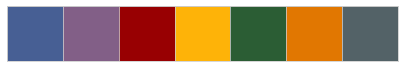

In [4]:
# import custom palette
import my_palette as mp

In [5]:
# read in actor dataset
actor_df = pd.read_json('../data_wrangling/capstone2_ref.json')

In [13]:
# observed DataFrame before aggregation
actor_df.head()

,person_id,name,movie_id,title,revenue,budget,profit,age,gender,order,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
0,2,Mark Hamill,16121,The Big Red One,2.273880e+07,1.419948e+07,8.539315e+06,28.674100,0,1,...,0,0,0,0,0,0,0,0,1,0
1,2,Mark Hamill,11,Star Wars,3.319102e+09,4.708566e+07,3.272016e+09,25.665140,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,Mark Hamill,14919,Batman: Mask of the Phantasm,9.944670e+06,1.062202e+07,-6.773465e+05,42.251381,0,1,...,0,0,0,0,1,0,0,1,0,0
3,2,Mark Hamill,1892,Return of the Jedi,1.490146e+09,8.417359e+07,1.405972e+09,31.663895,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2,Mark Hamill,16220,Wizards,3.930685e+07,5.240914e+06,3.406594e+07,25.377660,0,4,...,1,0,0,0,0,0,1,0,0,0


In [15]:
def aggregate_data(data):
    """Return aggregated DataFrame grouped by each actor"""
    # aggregate while making counts of genres and taking the average of all other values
    agg_actor_df = data.groupby('person_id').agg(
        {'revenue': np.mean, 'budget': np.mean, 'age': np.mean, 'gender': 'first', 
         'order':np.mean, 'popularity':np.mean, 'release_date': np.mean, 
         'runtime': np.mean, 'usa': 'first', 'vote_average': np.mean, 
         'vote_count': np.mean, 'action': np.sum, 'adventure': np.sum, 
         'animation': np.sum, 'comedy': np.sum, 'crime': np.sum, 'drama': np.sum, 
         'family': np.sum, 'fantasy': np.sum, 'history': np.sum, 'horror': np.sum, 
         'music': np.sum, 'mystery': np.sum, 'romance': np.sum, 'science_fiction': np.sum, 
         'thriller': np.sum, 'war': np.sum, 'western': np.sum})
    
    return agg_actor_df

In [99]:
def get_target_year_data(all_years_df, target_year, predictor_years_length=10):
    """Return data from range of previous years and target to predict on specified date"""
    # set range of data to use for training
    training_years_start = target_year - predictor_years_length - 1
    training_years_end = target_year - 1
    # extract data to build models to predict on specified target year
    training_actor_df = all_years_df[
        (all_years_df['release_date'] >= training_years_start) & 
        (all_years_df['release_date'] < training_years_end)]
    # extract data for target year
    test_actor_df = all_years_df[all_years_df['release_date'] == target_year]    
    # aggregate date grouped by actor
    training_df = aggregate_data(training_actor_df)
    test_df = aggregate_data(test_actor_df)

    return training_df, test_df

In [100]:
# break off actors who worked in the 90s to predict on the year 2000
nineties_training_df, nineties_test_df = get_target_year_data(actor_df, 2000,  30)

In [59]:
# separate training data into features and target
nineties_X = nineties_training_df.drop('revenue', axis=1)
nineties_y = nineties_training_df['revenue']

In [107]:
def get_cv_results(features, target, params={}):
    """Get 10 fold cross validation training and test errors"""
    model = xgb.XGBRegressor(n_jobs=-1, **params)
    # perform 10 fold cross validation
    cv_results = cross_validate(model, features, target, cv=10, n_jobs=-1,
                               scoring='neg_mean_absolute_error', return_train_score=True)
    # get average errors
    train_mae = np.mean(np.absolute(cv_results['train_score']))
    test_mae = np.mean(np.absolute(cv_results['test_score']))

    return train_mae, test_mae

In [110]:
def print_cv_results(features, target, params={}):
    """Print CV test error & percent difference between training and test errors"""
    train_mae, test_mae = get_cv_results(features, target, params)
    # compute extent of overfitting (percent difference between training & test errors)
    val_error = np.absolute(train_mae - test_mae) / test_mae    
    print('Test Error: ${:,.2f}'.format(
        test_mae) + '   Percent off from Training Error: {:,.2f}%'.format(val_error * 100))

In [111]:
# print test error and overfit error for nineties data with base XGB model
print_cv_results(nineties_X, nineties_y)

Test Error: $68,117,166.35   Percent off from Training Error: 15.89%


In [112]:
def test_predictor_year_range(all_years_df, target_year, max_years):
    """Return DataFrame with CV results over ranges of selected predictor years"""
    # set length of largest range of predictor years
    predictor_years_max_length = np.arange(1, max_years + 1)
    # Create defaultdict to sort CV results
    results_dict = defaultdict(list)
    for num_years in predictor_years_max_length:
        # extract data for range of years
        training_df, test_df = get_target_year_data(all_years_df, target_year, num_years)
        # get size of data
        num_training_samples = training_df.shape[0]
        num_actors_to_predict = test_df.shape[0]
        results_dict['num_samples'].append(num_training_samples)
        results_dict['num_targets'].append(num_actors_to_predict)        
        # split dat into features and target
        training_X = training_df.drop('revenue', axis=1)
        training_y = training_df['revenue']
        # run 10 fold cross validation and collect training and test errors
        train_mae, test_mae = get_cv_results(training_X, training_y)
        # compute extent of overfitting (percent difference between training & test errors)
        val_error = np.absolute(train_mae - test_mae) / test_mae
        # store values in defaultdict
        results_dict['train_mae'].append(train_mae)
        results_dict['test_mae'].append(test_mae)
        results_dict['val_error'].append(val_error)
    # assemble results into DataFrame
    df = pd.DataFrame(results_dict)
    
    return df

In [113]:
two_thousand_df = test_predictor_year_range(actor_df, 2000, 50)

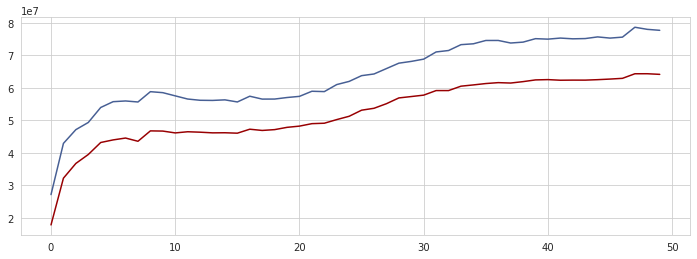

In [116]:
sns.lineplot(data=two_thousand_df['train_mae'], color=mp.colors(2))
sns.lineplot(data=two_thousand_df['test_mae'], color=mp.colors(0));

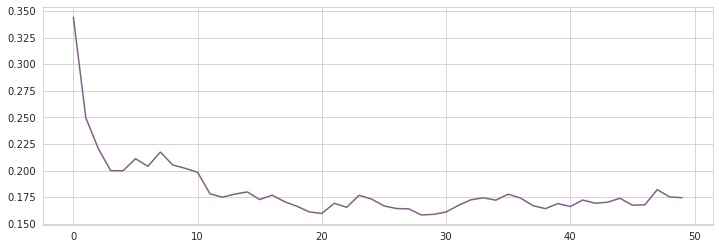

In [117]:
sns.lineplot(data=two_thousand_df['val_error'], color=mp.colors(1));

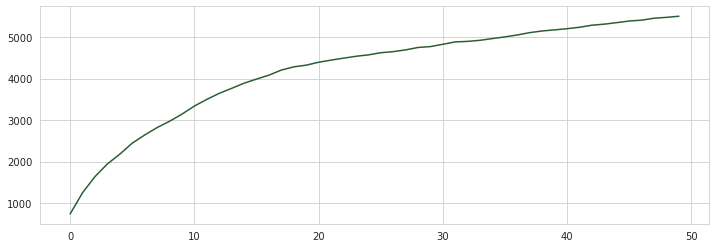

In [118]:
sns.lineplot(data=two_thousand_df['num_samples'], color=mp.colors(4));

In [56]:
# separate data to predict into features and target
two_thousand_X = nineties_test_df.drop('revenue', axis=1)
two_thousand_y = nineties_test_df['revenue']

In [ ]:
def print_cv_results(features, target, params={}):
    """Print CV test error & percent difference between training and test errors"""
    train_mae, test_mae = get_cv_results(features, target, params)
    # compute extent of overfitting (percent difference between training & test errors)
    val_error = np.absolute(train_mae - test_mae) / test_mae
    print('Test Error: ${:,.2f}'.format(
        test_mae) + '   Percent off from Training Error: {:,.2f}%'.format(val_error * 100))

In [121]:
def print_cv_mae(features, target, params={}):
    """Print CV average mean absolute error and mean absolute error range"""
    model = xgb.XGBRegressor(n_jobs=-1, **params)
    # perform 10 fold cross validation
    cv_results = cross_val_score(model, features, target, 
                                 scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
    results = np.absolute(cv_results)
    # get scores range
    results_range = (np.min(results), np.max(results))
    # get average score
    ave_result = np.mean(results)
        
    return f'Average MAE: ${ave_result:,.2f} \
    CV Range: (${results_range[0]:,.2f}, ${results_range[1]:,.2f})'

In [122]:
# predict on year two-thousand data with base model
print_cv_mae(two_thousand_X, two_thousand_y)

'Average MAE: $24,231,073.97     CV Range: ($16,818,074.28, $50,252,568.46)'

In [24]:
# split dataset
nineties_X_train, nineties_X_test, nineties_y_train, nineties_y_test = train_test_split(
    nineties_X, nineties_y, test_size=0.2, random_state=27)